In [29]:
import pandas as pd
from pathlib import Path
import numpy as np
import os
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

In [3]:
#Gefilterte Datensätze wieder den Variablen zuweisen:
output_dir = Path("Data/filtered_data")
csv_path_links = output_dir / "links_cleaned.csv"
csv_path_movies = output_dir / "movies_cleaned.csv"
csv_path_ratings = output_dir / "ratings_cleaned.csv"
csv_path_tags = output_dir / "tags_cleaned.csv"
links = pd.read_csv(csv_path_links)
movies = pd.read_csv(csv_path_movies)
ratings = pd.read_csv(csv_path_ratings)
tags = pd.read_csv(csv_path_tags)

In [4]:
output_dir = Path("Data/Train_Test_Validate")
csv_path_train = output_dir / "train_df.csv"
csv_path_test = output_dir / "test_df.csv"
training = pd.read_csv(csv_path_train)
test = pd.read_csv(csv_path_test)
csv_path_test_masked = output_dir / "test_df_masked.csv"
test_masked = pd.read_csv(csv_path_test_masked)

# Aufgabe 2

In [11]:
def calculate_biases(df, beta_u=20, beta_i=20, iteration=10):
    #erstellt einen Key, wenn der aufgerufene Key nicht existiert
    b_i = defaultdict(float)
    b_u = defaultdict(float)
    #Globalen Durchschnitt berechnen
    mu = df["rating"].mean()

    # Vorab gruppieren nach User und Movie
    user_groups = df.groupby("userId")
    movie_groups = df.groupby("movieId")

    for _ in range(iteration):
        # Update b_u
        for user_id, group in user_groups:
            numer = (group["rating"] - mu - group["movieId"].map(b_i)).sum()#Summe der Abweichung für den nutzer
            denom = beta_u + len(group) #Filme mit weniger bewertungen sollen damit stärker reguliert werden
            b_u[user_id] = numer / denom #berechneter user bias

        # Update b_i
        for movie_id, group in movie_groups:
            numer = (group["rating"] - mu - group["userId"].map(b_u)).sum()#Summe der Abweichung für den Film
            denom = beta_i + len(group)
            b_i[movie_id] = numer / denom #berechneter item bias

    return mu, dict(b_u), dict(b_i)

mu_baseline, b_u_baseline, b_i_baseline = calculate_biases(ratings)


KeyboardInterrupt



In [ ]:
#Vorhersagen für die nicht bewerteten Filme eines Users
def predict(mu, b_u, b_i, user_ID, unrated_Itmes):
    prediction = []
    for item_ID in unrated_Itmes:
        predicted_rating = mu + b_u[user_ID] + b_i[item_ID]
        prediction.append((item_ID, predicted_rating))
    prediction.sort(key=lambda x: x[1], reverse=True)
    return prediction

#Vorhersagen für Top-N Empfehlungen
def get_top_n_reco(df,mu, b_u, b_i, user_ID, N = 20):
    #Filtern nach welche Filme bereits von User bewertet wurden
    rated = df[df["userId"] == user_ID]["movieId"]
    #Liste erstellen für alle nicht bertetetn Filme
    unrated_prod = [item for item in df["movieId"].unique() if item not in rated]
    #Vorhersage berechnen wie der Nutzer den Film finden würde
    top_n_pred = predict(mu, b_u, b_i,user_ID, unrated_prod)[:N]
    print(f"\n Top {N} Empfehlungen für Benutzer {user_ID} sind:")
    for rank, (movie_id, score) in enumerate(top_n_pred, start=1):
        movie_title = movies.loc[movies['movieId'] == movie_id, 'title'].values[0]
        print(f"{rank}. {movie_title} - Vorhergesagter Wert: {score:.2f}")


get_top_n_reco(ratings,mu_baseline, b_u_baseline, b_i_baseline, 1)
get_top_n_reco(ratings,mu_baseline, b_u_baseline, b_i_baseline, 3)
get_top_n_reco(ratings,mu_baseline, b_u_baseline, b_i_baseline, 7)

In [ ]:
def random_recom(df, user_ID, mu, b_u, b_i, movies, N=20):
    # Filme, die der User schon gesehen hat
    rated = df[df['userId'] == user_ID]['movieId']
    
    # Alle anderen Filme
    unrated_prod = [item for item in df["movieId"].unique() if item not in rated.values]
    
    # Zufällige Auswahl
    random_recommendations = random.sample(unrated_prod, min(N, len(unrated_prod)))
    
    print(f"\nZufällige Empfehlungen für User {user_ID} mit vorhergesagtem Score:")
    
    for rank, movie_id in enumerate(random_recommendations, start=1):
        title = movies.loc[movies['movieId'] == movie_id, 'title'].values[0]
        
        # Vorhersage berechnen, wenn User- oder Item-Bias fehlen, nutze 0
        bu = b_u.get(user_ID, 0)
        bi = b_i.get(movie_id, 0)
        pred_score = mu + bu + bi
        
        print(f"{rank}. {title} — Vorhergesagter Score: {pred_score:.2f}")
        
random_recom(ratings, user_ID=1, mu=mu_baseline, b_u=b_u_baseline, b_i=b_i_baseline, movies=movies, N=20)
random_recom(ratings, user_ID=3, mu=mu_baseline, b_u=b_u_baseline, b_i=b_i_baseline, movies=movies, N=20)
random_recom(ratings, user_ID=7, mu=mu_baseline, b_u=b_u_baseline, b_i=b_i_baseline, movies=movies, N=20)

# Aufgabe 3

In [106]:
def mask_test_all_but_percent(test_df, user_col="userId", rating_col="rating", percent_keep=0.3, random_seed=42):
    np.random.seed(random_seed)
    masked_list = []

    for user_id in test_df[user_col].unique():
        user_data = test_df[test_df[user_col] == user_id]

        if len(user_data) > 1:  # Nur maskieren, wenn der Nutzer mehr als eine Bewertung hat
            n_keep = int(len(user_data) * percent_keep)  # Anzahl der Bewertungen, die behalten werden sollen (prozentual)
            keep = user_data.sample(n=n_keep, random_state=random_seed)  # Zufällige Auswahl der Bewertungen
            mask = user_data.drop(keep.index).copy()  # Die Bewertungen, die nicht behalten werden
            mask[rating_col] = np.nan  # Setze Rating auf NaN für die maskierten Bewertungen
            user_masked = pd.concat([keep, mask])  # Kombiniere behaltene und maskierte Bewertungen
        else:
            user_masked = user_data  # Keine Maskierung, wenn nur eine Bewertung vorhanden ist

        masked_list.append(user_masked)

    test_masked = pd.concat(masked_list).reset_index(drop=True)
    return test_masked

# Test mit einer beispielhaften DataFrame
df_test_masked = mask_test_all_but_percent(test, percent_keep=0.3)

# In CSV abspeichern
output_dir = Path("Data/Train_Test_Validate")
df_test_masked.to_csv(os.path.join(output_dir, f"test_df_masked.csv"), index=False)

In [120]:
#debug_TEST
def cross_validation(dataset, parts=5, keep_frac=0.2, random_state=42):
    user_unique = dataset["userId"].unique()
    user_shuffled = pd.Series(user_unique).sample(frac=1, random_state=random_state).values
    user_folds = np.array_split(user_shuffled, parts)

    train_sets = []
    validation_visible_sets = []
    validation_ground_truth_sets = []

    for fold_users in user_folds:
        is_validation = dataset["userId"].isin(fold_users)
        train_set = dataset[~is_validation].copy()
        validation_set = dataset[is_validation].copy()

        # Sichtbare Bewertungen (All-but-X%)
        validation_visible = mask_test_all_but_percent(validation_set, percent_keep=keep_frac)

        # Maskierte Bewertungen = Ground Truth
        validation_ground_truth = validation_set.merge(
            validation_visible,
            how="outer",
            on=["userId", "movieId", "rating", "timestamp"],
            indicator=True
        )
        validation_ground_truth = validation_ground_truth[
            validation_ground_truth["_merge"] == "left_only"
        ].drop(columns=["_merge"])

        train_sets.append(train_set)
        validation_visible_sets.append(validation_visible)
        validation_ground_truth_sets.append(validation_ground_truth)

    return train_sets, validation_visible_sets, validation_ground_truth_sets


In [121]:
#Versuch
df_train, df_val_visible, df_val_ground = cross_validation(training, parts=5, keep_frac=0.2)

output_dir = Path("Data/Train_Test_Validate/Versuch")
output_dir.mkdir(parents=True, exist_ok=True)

for idx in range(5):
    df_train[idx].to_csv(output_dir / f"train_set_{idx+1}.csv", index=False)
    df_val_visible[idx].to_csv(output_dir / f"validate_masked_{idx+1}.csv", index=False)
    df_val_ground[idx].to_csv(output_dir / f"validate_groundtruth_{idx+1}.csv", index=False)

In [114]:
#Versuch
output_dir = Path("Data/Train_Test_validate/Versuch")

# Trainingssets
train_set_1 = pd.read_csv(output_dir / "train_set_1.csv")
train_set_2 = pd.read_csv(output_dir / "train_set_2.csv")
train_set_3 = pd.read_csv(output_dir / "train_set_3.csv")
train_set_4 = pd.read_csv(output_dir / "train_set_4.csv")
train_set_5 = pd.read_csv(output_dir / "train_set_5.csv")

# Validierungssätze (sichtbare Ratings, All-but-X%)
validate_masked_1 = pd.read_csv(output_dir / "validate_masked_1.csv")
validate_masked_2 = pd.read_csv(output_dir / "validate_masked_2.csv")
validate_masked_3 = pd.read_csv(output_dir / "validate_masked_3.csv")
validate_masked_4 = pd.read_csv(output_dir / "validate_masked_4.csv")
validate_masked_5 = pd.read_csv(output_dir / "validate_masked_5.csv")

# Ground Truths (maskierte Bewertungen, zum Auswerten)
validate_groundtruth_1 = pd.read_csv(output_dir / "validate_groundtruth_1.csv")
validate_groundtruth_2 = pd.read_csv(output_dir / "validate_groundtruth_2.csv")
validate_groundtruth_3 = pd.read_csv(output_dir / "validate_groundtruth_3.csv")
validate_groundtruth_4 = pd.read_csv(output_dir / "validate_groundtruth_4.csv")
validate_groundtruth_5 = pd.read_csv(output_dir / "validate_groundtruth_5.csv")

In [15]:
# Mean Absolute Error (MAE)
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(np.array(y_true) - np.array(y_pred)))

# Root Mean Square Error (RMSE)
def root_mean_square_error(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

# Precision@N berechnen
def precision_at_n(predictions, relevant_items, N=15, threshold=4.0):
    # Filtere relevante Items
    relevant_items = [item for item in relevant_items if item[1] >= threshold]
    
    # Berechne die Top-N Empfehlungen
    top_n_predictions = sorted(predictions, key=lambda x: x[1], reverse=True)[:N]
    
    # Berechne Precision
    relevant_in_top_n = sum(1 for item in top_n_predictions if item[0] in [x[0] for x in relevant_items])
    return relevant_in_top_n / N if N > 0 else 0

# Recall@N berechnen
def recall_at_n(predictions, relevant_items, N=15, threshold=4.0):
    # Filtere relevante Items
    relevant_items = [item for item in relevant_items if item[1] >= threshold]
    
    # Berechne die Top-N Empfehlungen
    top_n_predictions = sorted(predictions, key=lambda x: x[1], reverse=True)[:N]
    
    # Berechne Recall
    relevant_in_top_n = sum(1 for item in top_n_predictions if item[0] in [x[0] for x in relevant_items])
    return relevant_in_top_n / len(relevant_items) if len(relevant_items) > 0 else 0

def precision_recall_at_n(predicted_list, true_list, N=15, threshold=4.0):
    precisions = []
    recalls = []

    for uid in predicted_list:
        if uid not in true_list:
            continue

        preds = predicted_list[uid]
        truths = true_list[uid]

        # Relevante Items im Ground Truth
        true_relevant = set(iid for iid, rating in truths if rating >= threshold)
        if not true_relevant:
            continue

        # Top-N vorhergesagte Items
        top_n = sorted(preds, key=lambda x: x[1], reverse=True)[:N]
        recommended = set(iid for iid, rating in top_n if rating >= threshold)

        # Schnittmenge
        rel_and_rec = recommended & true_relevant

        precision = len(rel_and_rec) / len(recommended) if recommended else 0
        recall = len(rel_and_rec) / len(true_relevant)

        precisions.append(precision)
        recalls.append(recall)

    return np.mean(precisions), np.mean(recalls)

# Aufgabe 4

In [8]:
#Anpassung, da ich true und prediction am besten direkt hier berechne deshalb compute_rmse
from sklearn.metrics import mean_squared_error
def compute_rmse(mu, b_u, b_i, test_df):
    preds = []   # Liste zur Speicherung der vorhergesagten Bewertungen
    actuals = [] # Liste zur Speicherung der tatsächlichen Bewertungen
    
    # Iteration über alle Zeilen des Test-Datensatzes
    for _, row in test_df.iterrows():
        # Extrahiere Nutzer-ID, Film-ID und tatsächliche Bewertung aus der aktuellen Zeile
        u, i, true_rating = row["userId"], row["movieId"], row["rating"]
        
        # Berechne die vorhergesagte Bewertung:
        # globale Durchschnittsbewertung + Nutzer-Bias + Item-Bias
        # Falls kein Bias vorhanden ist, verwende 0 als Standardwert
        pred_rating = mu + b_u.get(u, 0) + b_i.get(i, 0)
        
        # Speichere die Vorhersage und die tatsächliche Bewertung
        preds.append(pred_rating)
        actuals.append(true_rating)
    
    # Berechne und gib die RMSE zwischen den tatsächlichen und vorhergesagten Bewertungen zurück
    return np.sqrt(mean_squared_error(actuals, preds))

In [22]:
# === Parameter und Ergebnis-Speicher ===
beta_values = [1, 5, 10, 20]
rmse_list, mae_values, precision_values, recall_values = [], [], [], []

train_sets = [pd.read_csv(output_dir / f"train_set_{i}.csv") for i in range(1, 6)]
validate_masked_sets = [pd.read_csv(output_dir / f"validate_masked_{i}.csv") for i in range(1, 6)]
validate_groundtruth_sets = [pd.read_csv(output_dir / f"validate_groundtruth_{i}.csv") for i in range(1, 6)]

# === Hauptschleife über alle Betas & Folds ===
for beta_u in beta_values:
    for beta_i in beta_values:
        all_rmse, all_mae, all_prec, all_rec = [], [], [], []

        for fold in range(5):
            train_set = train_sets[fold]
            val_masked = validate_masked_sets[fold]
            val_groundtruth = validate_groundtruth_sets[fold]

            mu, b_u, b_i = calculate_biases(train_set, beta_u=beta_u, beta_i=beta_i, iteration=3)

            # Vorhersagen auf Groundtruth
            predictions = [mu + b_u.get(u, 0) + b_i.get(i, 0)
                           for u, i in zip(val_groundtruth["userId"], val_groundtruth["movieId"])]
            true_ratings = val_groundtruth["rating"].values

            rmse = compute_rmse(mu, b_u, b_i, val_groundtruth)
            mae = mean_absolute_error(true_ratings, predictions)

            user_preds = defaultdict(list)
            user_truths = defaultdict(list)

            for u, i, true_r, pred_r in zip(val_groundtruth["userId"], val_groundtruth["movieId"], val_groundtruth["rating"], predictions):
                user_preds[u].append((i, pred_r))
                user_truths[u].append((i, true_r))

            precision, recall = precision_recall_at_n(user_preds, user_truths, N=15, threshold=4.0)

            all_rmse.append(rmse)
            all_mae.append(mae)
            all_prec.append(precision)
            all_rec.append(recall)

        rmse_list.append((beta_u, beta_i, np.mean(all_rmse)))
        mae_values.append((beta_u, beta_i, np.mean(all_mae)))
        precision_values.append((beta_u, beta_i, np.mean(all_prec)))
        recall_values.append((beta_u, beta_i, np.mean(all_rec)))

        print(f"β_u: {beta_u}, β_i: {beta_i}, RMSE: {np.mean(all_rmse):.4f}, MAE: {np.mean(all_mae):.4f}, "
              f"Precision@N: {np.mean(all_prec):.4f}, Recall@N: {np.mean(all_rec):.4f}")

# === Heatmaps erzeugen ===
def plot_heatmap(df, metric_name, cmap="viridis"):
    pivot = df.pivot(index="beta_u", columns="beta_i", values=metric_name)
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap=cmap)
    plt.title(f"{metric_name} Heatmap für verschiedene β-Werte")
    plt.xlabel("β_i")
    plt.ylabel("β_u")
    plt.show()

df_results = pd.DataFrame(rmse_list, columns=["beta_u", "beta_i", "rmse"])
df_mae = pd.DataFrame(mae_values, columns=["beta_u", "beta_i", "mae"])
df_precision = pd.DataFrame(precision_values, columns=["beta_u", "beta_i", "precision"])
df_recall = pd.DataFrame(recall_values, columns=["beta_u", "beta_i", "recall"])

plot_heatmap(df_results, "rmse")
plot_heatmap(df_mae, "mae")
plot_heatmap(df_precision, "precision")
plot_heatmap(df_recall, "recall")

β_u: 1, β_i: 1, RMSE: 0.9561, MAE: 0.7399, Precision@N: 0.7314, Recall@N: 0.2016
β_u: 1, β_i: 5, RMSE: 0.9619, MAE: 0.7442, Precision@N: 0.7425, Recall@N: 0.1837


KeyboardInterrupt: 

# Aufgabe 5

In [94]:
def create_urm(data, index="userId", colums="movieId", values="rating"):
    urm = data.pivot(index=index, columns=colums, values=values)
    return urm

urm_masked = create_urm(train_set_1, "userId", "movieId", "rating")

In [24]:


def cosine_similarity_items(matrix):
    # Mean-Centering pro Item
    item_means = matrix.mean(axis=0) #axis = 0 bedeutet den Mittelwert pro Spalte zu berechnen
    matrix_centered = matrix.sub(item_means, axis=1) # subtrahiert spaltenweise (axis = 1) den jeweiligen Mittelwert des Items ab

    return pd.DataFrame(
        cosine_similarity(np.nan_to_num(matrix_centered.T)),
        index=matrix.columns,
        columns=matrix.columns
    )

def cosine_similarity_users(matrix):
    # Mean-Centering pro User
    user_means = matrix.mean(axis=1) #axis = 1 bedeutet den Mittelwert pro Zeile zu berechnen
    matrix_centered = matrix.sub(user_means, axis=0) # subtrahiert zeilenweise (axis = 0) den jeweiligen Mittelwert des Users ab

    return pd.DataFrame(
        cosine_similarity(np.nan_to_num(matrix_centered)),
        index=matrix.index,
        columns=matrix.index
    )

In [25]:
def pearson_similarity_items(matrix):
    # Mittelwert zentrieren je Item (Spalte)
    item_means = matrix.mean(axis=1)  # Mittelwert pro Item (Spalte)
    matrix_centered = matrix.sub(item_means, axis=0)  # Subtrahiere Mittelwert von jedem Item (Spalte)
    
    # Berechne die Pearson-Ähnlichkeit zwischen den Items
    pearson_sim_matrix = matrix_centered.corr(method='pearson').fillna(0)

    return pearson_sim_matrix



def pearson_similarity_users(matrix):
    # Mittelwert zentrieren je User (Zeile)
    centered = matrix.sub(matrix.mean(axis=1), axis=0).fillna(0)# subtrahiert zeilenweise den jeweiligen Mittelwert pro Zeile des Items ab und ersetzt anschliessend alle NA Werte mit 0
    # Jetzt Zeilen miteinander korrelieren (User-User-Similarity) und anschliessend die NA-Werte mit 0 ersetzen
    similarity = centered.T.corr().fillna(0)
    return similarity

In [27]:
def predict_ratings_item_based(user_id, item_similarity, urm_, k=30):
    user_ratings = urm_.loc[user_id]
    user_rated_items = user_ratings.dropna().index
    
    all_items = urm_.columns
    predictions = {}

    for target_item in all_items:
        if target_item in user_rated_items:
            continue  # Keine Vorhersage für bereits bewertete Items

        # Ähnlichkeiten zum Ziel-Item für alle vom User bewerteten Items
        sims = item_similarity.loc[target_item, user_rated_items]

        # Bewertungen des Users zu diesen Items
        ratings = user_ratings.loc[user_rated_items]

        # Top-k ähnlichste Items auswählen (nach Betrag der Ähnlichkeit sortieren)
        top_k = sims.abs().sort_values(ascending=False).head(k).index
        top_sims = sims.loc[top_k]
        top_ratings = ratings.loc[top_k]

        numerator = (top_sims * top_ratings).sum()
        denominator = top_sims.abs().sum()

        if denominator != 0:
            predictions[target_item] = numerator / denominator
        else:
            predictions[target_item] = np.nan  # oder z. B. globaler Mittelwert als Fallback

    # Rückgabe als Serie sortiert
    return pd.Series(predictions).dropna().sort_values(ascending=False)


def print_top_n_item_similarity(user_ids, urm_, method, movies_df=None, n=20, k=30):
    if method == "cosine":
        item_sim_matrix = cosine_similarity_items(urm_)
    elif method == "pearson":
        item_sim_matrix = pearson_similarity_items(urm_)
    else:
        print(f"Invalid method: {method}. Only 'cosine' or 'pearson' are allowed.")
        return
        
    use_titles = movies_df is not None and "movieId" in movies_df.columns and "title" in movies_df.columns
        
    if use_titles:
        movies_itembased = movies_df.set_index("movieId")

    for uid in user_ids:
        if uid in urm_.index:
            recs = predict_ratings_item_based(uid, item_sim_matrix, urm_, k)
            top_n = recs.head(n)
        else:
            global_avg_ratings = urm_.mean(axis=0)
            top_n = global_avg_ratings.sort_values(ascending=False).head(n)
            
        top_n.index = top_n.index.astype(int)
        if use_titles:
            valid_ids = top_n.index.intersection(movies_itembased.index)
            movie_titles = movies_itembased.loc[valid_ids, "title"]
            
            results = pd.DataFrame({
                "Predicted Rating": top_n.loc[valid_ids].values,
                "Movie Title": movie_titles.values
            })
            
            print(f"\nTop {n} recommendations for User {uid} (Item-Based, {method}):")
            print(results.set_index("Movie Title"))
        else:
            results = pd.DataFrame({
                "Movie ID": top_n.index,
                "Predicted Rating": top_n.values
            })
            
            print(f"\nTop {n} recommendations for User {uid} (Item-Based, {method}, only Movie IDs):")
            print(results.set_index("Movie ID"))


In [96]:
print_top_n_item_similarity(user_ids = [131,140,155], urm_ = urm_masked, method = "cosine")


Top 20 recommendations for User 131 (Item-Based, cosine, only Movie IDs):
          Predicted Rating
Movie ID                  
1998              3.870138
828               3.823000
141               3.816997
129354            3.799834
159858            3.744337
2371              3.655502
903               3.644542
149354            3.636094
1201              3.620499
114935            3.615880
32                3.615602
3104              3.615266
67197             3.613450
1252              3.609399
2110              3.608790
63540             3.605383
2005              3.601639
8132              3.594382
1225              3.585089
118900            3.579523

Top 20 recommendations for User 140 (Item-Based, cosine, only Movie IDs):
          Predicted Rating
Movie ID                  
82459             4.046617
63113             4.037557
88744             3.974816
30825             3.964298
2355              3.952560
45720             3.949062
933               3.909540
46578        

In [97]:
print_top_n_item_similarity(user_ids = [131,140,155], urm_ = urm_masked, method = "pearson")


Top 20 recommendations for User 131 (Item-Based, pearson, only Movie IDs):
          Predicted Rating
Movie ID                  
189333            4.000000
171011            4.000000
44889             4.000000
389               4.000000
828               4.000000
1662              4.000000
1629              4.000000
165639            3.916667
105653            3.916667
175485            3.916667
31923             3.857143
5288              3.833333
6629              3.833333
536               3.750000
3224              3.750000
3330              3.750000
7084              3.750000
6051              3.750000
140110            3.655571
8405              3.642857

Top 20 recommendations for User 140 (Item-Based, pearson, only Movie IDs):
          Predicted Rating
Movie ID                  
171765            4.076923
148956            4.000000
31184             4.000000
161580            4.000000
55451             4.000000
167018            3.833333
4965              3.816667
187031     

In [37]:
def predict_ratings_user_based_(user_id, similarity_matrix, rating_matrix, k=30):
    #User selbst wurd entfertn da er nicht mit dsich verglichen werden soll
    sim_users = similarity_matrix[user_id].drop(user_id).dropna()
    #Welche top-k User sind mit Ursprung user Ähnlich
    top_k_users = sim_users.sort_values(ascending=False).head(k)
    
    # Mittels gewichtung wird der Ähnlcihste user gesucht
    weighted_sum = (rating_matrix.loc[top_k_users.index].T * top_k_users).T.sum()
    sim_sum = top_k_users.abs().sum()
    
    user_mean = rating_matrix.loc[user_id].mean()
    predicted_ratings = user_mean + (weighted_sum / sim_sum) #Addiert den in der Similarity abgezogenen Mittelwert wieder drauf

    return predicted_ratings

def print_top_n_user_similarity(user_ids: list, urm_,method, movies_df = None, n=20, k=30):
    if method == "cosine":
        user_sim_matrix = cosine_similarity_users(urm_)
    elif method == "pearson":
        user_sim_matrix = pearson_similarity_users(urm_)
    else:
        print(f"Die Methode ist nicht vorhanden – bitte 'cosine' oder 'pearson' verwenden (nicht '{method}').")
        return

    use_titles = movies_df is not None and "movieId" in movies_df.columns and "title" in movies_df.columns
    if use_titles:
        movies_user = movies_df.set_index("movieId")

    for uid in user_ids:
        if uid in urm_.index:
            recs = predict_ratings_user_based_(uid, user_sim_matrix, urm_, k)
            top_n = recs.sort_values(ascending=False).head(n)
        else:
            global_avg_ratings = urm_.mean(axis=0)
            top_n = global_avg_ratings.sort_values(ascending=False).head(n)

        top_n.index = top_n.index.astype(int)

        if use_titles:
            valid_ids = top_n.index[top_n.index.isin(movies_user.index)]
            movie_titles = movies_user.loc[valid_ids, "title"]
            results = pd.DataFrame({
                "Predicted Rating": top_n.loc[valid_ids].values,
                "Movie Title": movie_titles.values
            })
            print(f"\nTop {n} Empfehlungen für User {uid} (User-Based, {method}):")
            print(results.set_index("Movie Title"))
        else:
            results = pd.DataFrame({
                "Movie ID": top_n.index,
                "Predicted Rating": top_n.values
            })
            print(f"\nTop {n} Empfehlungen für User {uid} (User-Based, {method}, nur Movie IDs):")
            print(results.set_index("Movie ID"))

In [98]:
print_top_n_user_similarity(user_ids = [131,140,155], urm_ = urm_masked, method = "cosine", movies_df=movies)


Top 20 Empfehlungen für User 131 (User-Based, cosine):
                                                    Predicted Rating
Movie Title                                                         
Pulp Fiction (1994)                                         7.182571
Shawshank Redemption, The (1994)                            7.049568
Godfather, The (1972)                                       6.595469
Silence of the Lambs, The (1991)                            6.497607
Taxi Driver (1976)                                          6.016356
Usual Suspects, The (1995)                                  5.997953
Fargo (1996)                                                5.896658
Fight Club (1999)                                           5.766669
Goodfellas (1990)                                           5.585128
Schindler's List (1993)                                     5.483413
Seven (a.k.a. Se7en) (1995)                                 5.474955
Reservoir Dogs (1992)                          

In [99]:
print_top_n_user_similarity(user_ids = [131,140,155], urm_ = urm_masked, method = "pearson", movies_df = movies)


Top 20 Empfehlungen für User 131 (User-Based, pearson):
                                                    Predicted Rating
Movie Title                                                         
Pulp Fiction (1994)                                         7.182571
Shawshank Redemption, The (1994)                            7.049568
Godfather, The (1972)                                       6.595469
Silence of the Lambs, The (1991)                            6.497607
Taxi Driver (1976)                                          6.016356
Usual Suspects, The (1995)                                  5.997953
Fargo (1996)                                                5.896658
Fight Club (1999)                                           5.766669
Goodfellas (1990)                                           5.585128
Schindler's List (1993)                                     5.483413
Seven (a.k.a. Se7en) (1995)                                 5.474955
Reservoir Dogs (1992)                         

# Aufgabe 6

In [88]:
def evaluate_rs_methods(user_ids, urm, true_ratings_df, ks=range(1, 51), N=15):
    # Dictionary zur Speicherung der Ergebnisse pro Methode
    results = {
        "user_cosine": [],
        "user_pearson": [],
        "item_cosine": [],
        "item_pearson": []
    }
    # Mapping von Methodenname zu entsprechender Similarity-Funktion
    methods = {
        "user_cosine": cosine_similarity_users,
        "user_pearson": pearson_similarity_users,
        "item_cosine": cosine_similarity_items,
        "item_pearson": pearson_similarity_items
    }
    
     # Iteration über alle Recommender-Methoden
    for method_name, sim_func in methods.items():
        print(method_name)
        # Prüfen, ob es sich um ein user-basiertes Modell handelt
        is_user_based = "user" in method_name
        # Berechne Similarity-Matrix
        sim_matrix = sim_func(urm)

        # Iteration über alle K-Werte (Anzahl der Nachbarn)
        for k in ks:
            all_preds = []  # Vorhergesagte Ratings
            all_truths = []  # Wahre Ratings
            precs = []  # Precision-Werte pro User
            recs = []   # Recall-Werte pro User

            for uid in user_ids:
                # Nur User verwenden, die in der URM enthalten sind
                if uid not in urm.index:
                    continue

                if is_user_based:
                    preds = predict_ratings_user_based_(uid, sim_matrix, urm, k)
                else:
                    preds = predict_ratings_item_based(uid, sim_matrix, urm, k)

                # Nur bekannte Bewertungen vergleichen
                true_ratings = true_ratings_df[true_ratings_df["userId"] == uid].dropna()
                # Vorhersagen mit tatsächlichen Bewertungen vergleichen
                for _, row in true_ratings.iterrows():
                    movie_id = row["movieId"]
                    if movie_id in preds.index:
                        all_preds.append(preds[movie_id])
                        all_truths.append(row["rating"])

                # Precision@N und Recall@N
                rec_list = list(preds.items())# (movieId, predicted_rating)
                truth_list = list(true_ratings[["movieId", "rating"]].itertuples(index=False, name=None))
                precs.append(precision_at_n(rec_list, truth_list, N=N))
                recs.append(recall_at_n(rec_list, truth_list, N=N))
                
            # RMSE und Durchschnittswerte berechnen (falls es Vergleichsdaten gibt)
            mae = mean_absolute_error(all_truths, all_preds) if all_truths else None
            rmse = root_mean_square_error(all_truths, all_preds) if all_truths else None
            avg_prec = np.nanmean(precs)
            avg_rec = np.nanmean(recs)
            # Speichere Ergebnisse (K, RMSE, Precision@N, Recall@N)
            results[method_name].append((k, mae, rmse, avg_prec, avg_rec))

    return results


In [77]:
def plot_metrics(results, N):
    for method, data in results.items():
        ks, mae, rmses, precs, recs = zip(*data)

        plt.figure(figsize=(15, 4))
        plt.suptitle(f"Evaluation für {method}")

        plt.subplot(1, 4, 1)
        plt.plot(ks, rmses, marker='o')
        plt.title("MAE")
        plt.xlabel("K")
        plt.ylabel("MAE")
        plt.ylim(bottom=0)
        
        plt.subplot(1, 4, 2)
        plt.plot(ks, rmses, marker='o')
        plt.title("RMSE")
        plt.xlabel("K")
        plt.ylabel("RMSE")
        plt.ylim(bottom=0)

        plt.subplot(1, 4, 3)
        plt.plot(ks, precs, marker='o')
        plt.title(f"Precision@{N}")
        plt.xlabel("K")
        plt.ylabel("Precision")
        plt.ylim(bottom=0)

        plt.subplot(1, 4, 4)
        plt.plot(ks, recs, marker='o')
        plt.title(f"Recall@{N}")
        plt.xlabel("K")
        plt.ylabel("Recall")
        plt.ylim(bottom=0)

        plt.tight_layout()
        plt.show()

user_cosine
user_pearson
item_cosine
item_pearson


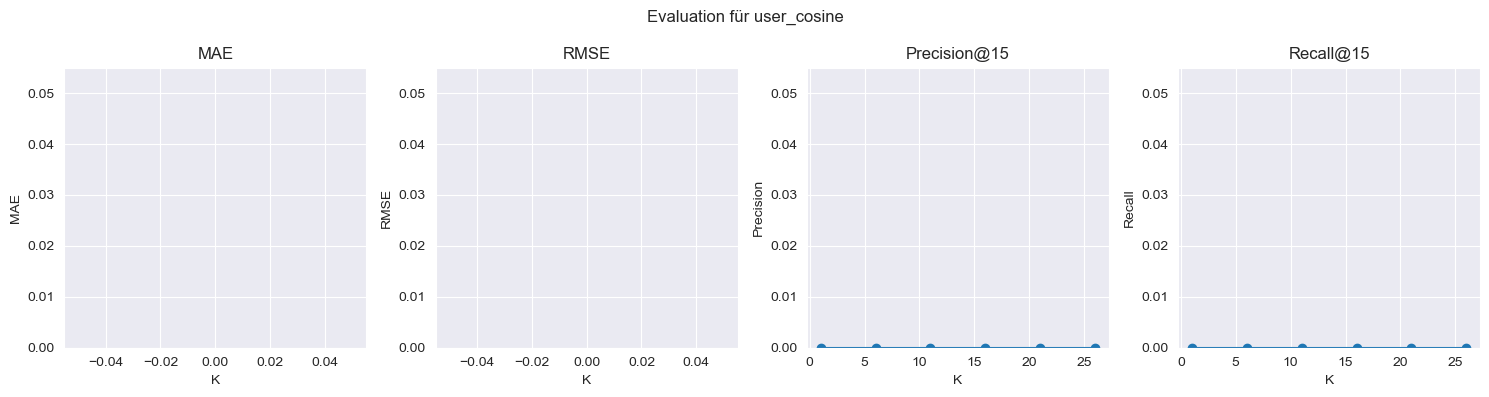

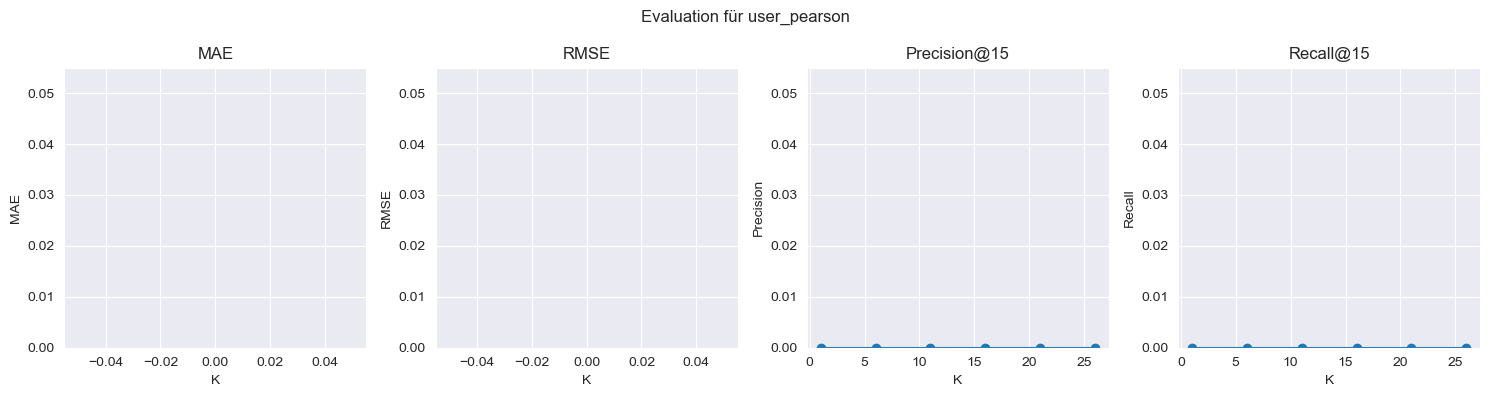

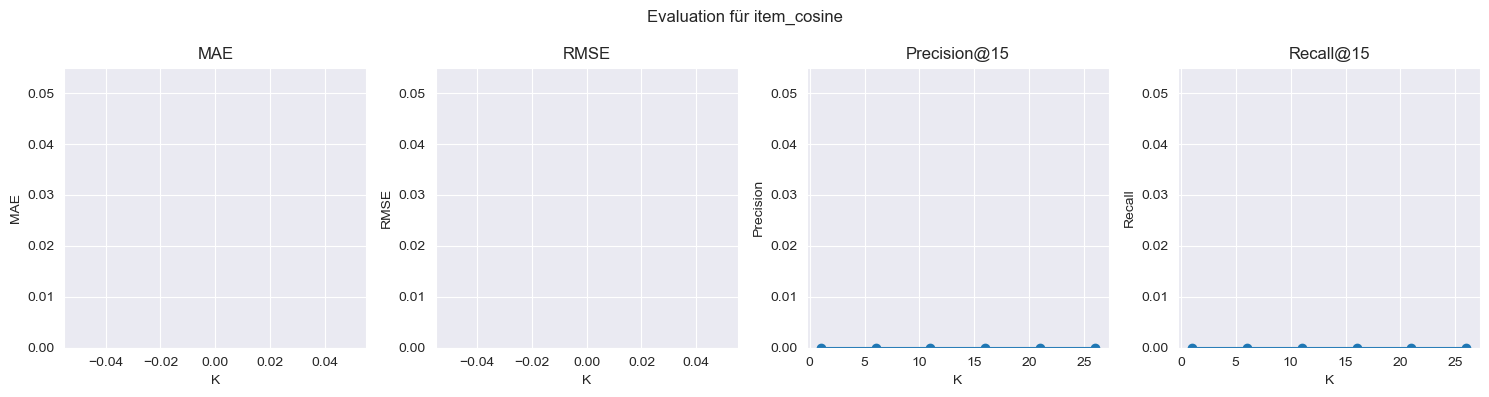

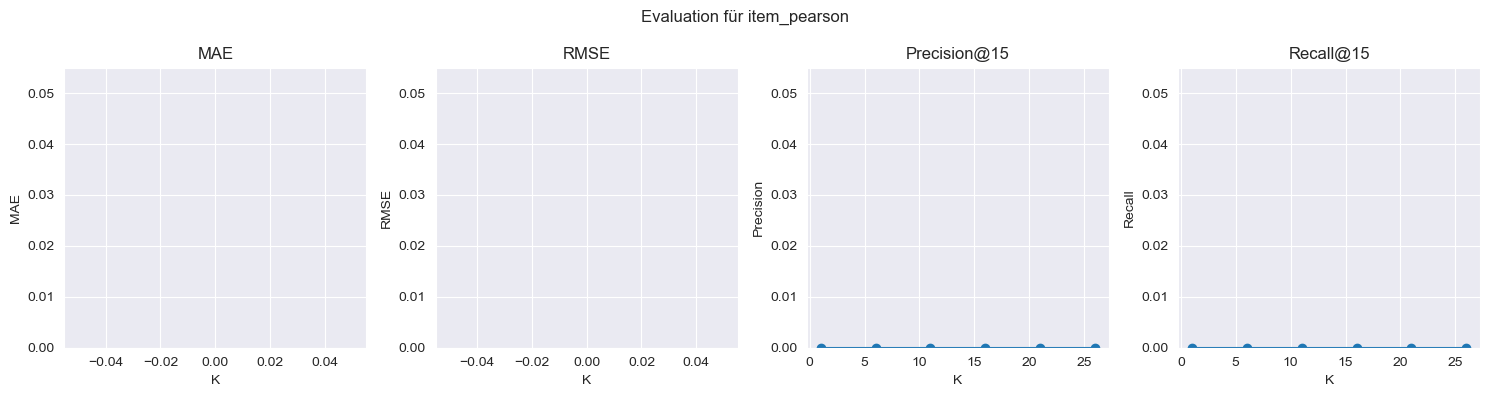

In [122]:
urm_validate = create_urm(validate_masked_1)
user_ids = [132,141,153]
results = evaluate_rs_methods(user_ids, urm_validate, validate_groundtruth_1, ks=range(1,30,5), N=15)
plot_metrics(results, N=15)

# Danach dringen user und ks wert anpassen

In [116]:
print(results)

{'user_cosine': [(5, None, None, 0.0, 0.0), (6, None, None, 0.0, 0.0), (7, None, None, 0.0, 0.0), (8, None, None, 0.0, 0.0), (9, None, None, 0.0, 0.0)], 'user_pearson': [(5, None, None, 0.0, 0.0), (6, None, None, 0.0, 0.0), (7, None, None, 0.0, 0.0), (8, None, None, 0.0, 0.0), (9, None, None, 0.0, 0.0)], 'item_cosine': [(5, None, None, 0.0, 0.0), (6, None, None, 0.0, 0.0), (7, None, None, 0.0, 0.0), (8, None, None, 0.0, 0.0), (9, None, None, 0.0, 0.0)], 'item_pearson': [(5, None, None, 0.0, 0.0), (6, None, None, 0.0, 0.0), (7, None, None, 0.0, 0.0), (8, None, None, 0.0, 0.0), (9, None, None, 0.0, 0.0)]}


# Aufgabe 7